# CoverType EDA

The [Covertype data set](https://archive.ics.uci.edu/ml/datasets/covertype) is a widely used dataset for benchmarking concept drift handling systems [ref](https://arxiv.org/pdf/1704.00023.pdf). The data set is formulated for the problem of predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. As such, the drift that exists in this dataset is expected to be categorical in nature, rather than time-dependent.

In this notebook, we:
- explore the the data set
- realize that significant drift is not present across the 4 `wilderness_area`'s
- apply [a method](https://arxiv.org/pdf/1704.00023.pdf) to induce drift
- save out the drifting dataset for experimentation

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
# specify columns to keep and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
soil_type_cols = [(f"soil_type_{i+1}", True) for i in range(40)]

col_names = col_names + wilderness_area_cols + soil_type_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv(
    "../data/covtype.data", header=None, names=[col_name[0] for col_name in col_names]
)

In [4]:
df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,...,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


## Preprocessing

By default this dataset poses a multiclass classification problem because the target variable `cover_type` takes on 7 different options. To simplify the problem here, we will only consider the two most populous classes and drop the rest of the data from consideration.


In [5]:
df.cover_type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: cover_type, dtype: int64

In [6]:
# drop records where cover_type isn't 1 or 2
df = df[df.cover_type.isin([1, 2])].reset_index(drop=True)

# label encode categorical columns (this will only change the cover_type column)
catcols = (col for col, iscat in col_names if iscat)

for col in catcols:
    df[col] = LabelEncoder().fit_transform(df[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


df = categorize(df, col_names)

## Induce Controlled Data Drift

### a. Use `wilderness_area` as a proxy for distribution change

In [7]:
df[[col for col, _ in wilderness_area_cols]].value_counts()

wilderness_area_1  wilderness_area_2  wilderness_area_3  wilderness_area_4
1                  0                  0                  0                    251914
0                  0                  1                  0                    212621
                   1                  0                  0                     27580
                   0                  0                  1                      3026
dtype: int64

- Wilderness area's are overlapping (aka non sequential), we might need to bunch these as a way to impose "artifical data drift"
- Also, they are not equally distributed


Let's reorder all records by this area.

In [8]:
# # order dataset by wilderness area
# df = pd.concat(
#     [df[df[f"wilderness_area_{i}"] == 1].reset_index(drop=True) for i in (1, 3, 2, 4)]
# ).reset_index(drop=True)


In [9]:
# df[df.wilderness_area_1==1]
# df[df.wilderness_area_3==1]
# df[df.wilderness_area_2==1]
# df[df.wilderness_area_4==1]

**This doesn't introduce controlled enough drift**

### b. Induce drift by changing features

In similar fashion as authors of [MD3 paper](https://arxiv.org/pdf/1704.00023.pdf), we can introduce drift in a controlled manner while retaining properties of the real world data by systematically swapping features.

Process:
1. Shuffle all data to remove unwanted concept drift
2. Figure out which features are most/least important to classification using kfold cross validation
3. Separate dataset by specified changepoints into chunks to represent differing concepts. In each chunk, select 25% of features (based on highest/lowest feature importance) per class and rotate them to induce drift. Features of high importance should impose "real drift", while lowest importance features should impose "virtual drift"

### 1. Shuffle all records and normalize

In [10]:
# df = df.sample(frac=1, random_state=42)
df = df.sample(frac=1, random_state=10)  # re-randomize

In [11]:
norm_df = pd.DataFrame(
    MinMaxScaler().fit_transform(df), index=df.index, columns=df.columns
)

In [12]:
df = norm_df.copy()

### 2. Find most/least important features

In [13]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

def fit_gscv(X, y):

    model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
    param_grid = {"clf__n_estimators": [5, 10, 20], "clf__max_depth": [5, 10, 20]}

    pipe = Pipeline(
        steps=[
            ("scaler", MinMaxScaler()),
            ("clf", model),
        ]
    )

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        refit=True,
        return_train_score=True,
    )

    gs.fit(X, y)
    
    return gs


CPU times: total: 219 ms
Wall time: 1.29 s


In [14]:
gs = fit_gscv(X, y)

print(
    f"""Best Params: {gs.best_params_} \n
        Best Train Score: {gs.cv_results_["mean_train_score"][gs.best_index_]} \n
        Best Test Score: {gs.best_score_}"""
)

Best Params: {'clf__max_depth': 20, 'clf__n_estimators': 20} 

        Best Train Score: 0.9391097673346934 

        Best Test Score: 0.9118230987096853


<Axes: ylabel='features'>

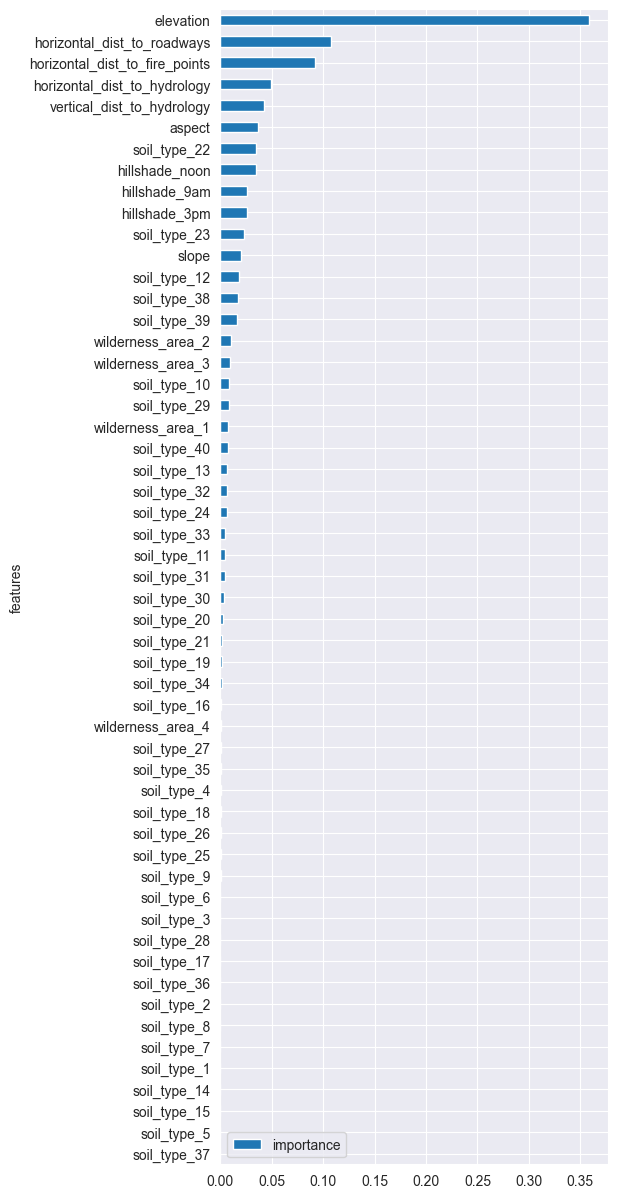

In [15]:
# plot global feature importances
importance_scores = gs.best_estimator_.named_steps["clf"].feature_importances_.tolist()
feature_names = X.columns.tolist()

pd.DataFrame(
    zip(feature_names, importance_scores), columns=["features", "importance"]
).set_index("features").sort_values("importance").plot(kind="barh", figsize=(5, 15))

**Because the soil types are not very useful to the model, lets disregard them all to simplify the problem**

In [16]:
df = df.drop(columns=[st for st, iscat in soil_type_cols if iscat])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

gs = fit_gscv(X, y)

print(
    f"""Best Params: {gs.best_params_} \n
        Best Train Score: {gs.cv_results_["mean_train_score"][gs.best_index_]} \n
        Best Test Score: {gs.best_score_}"""
)

Best Params: {'clf__max_depth': 20, 'clf__n_estimators': 20} 

        Best Train Score: 0.9819647332435615 

        Best Test Score: 0.9414267837384772


<Axes: ylabel='features'>

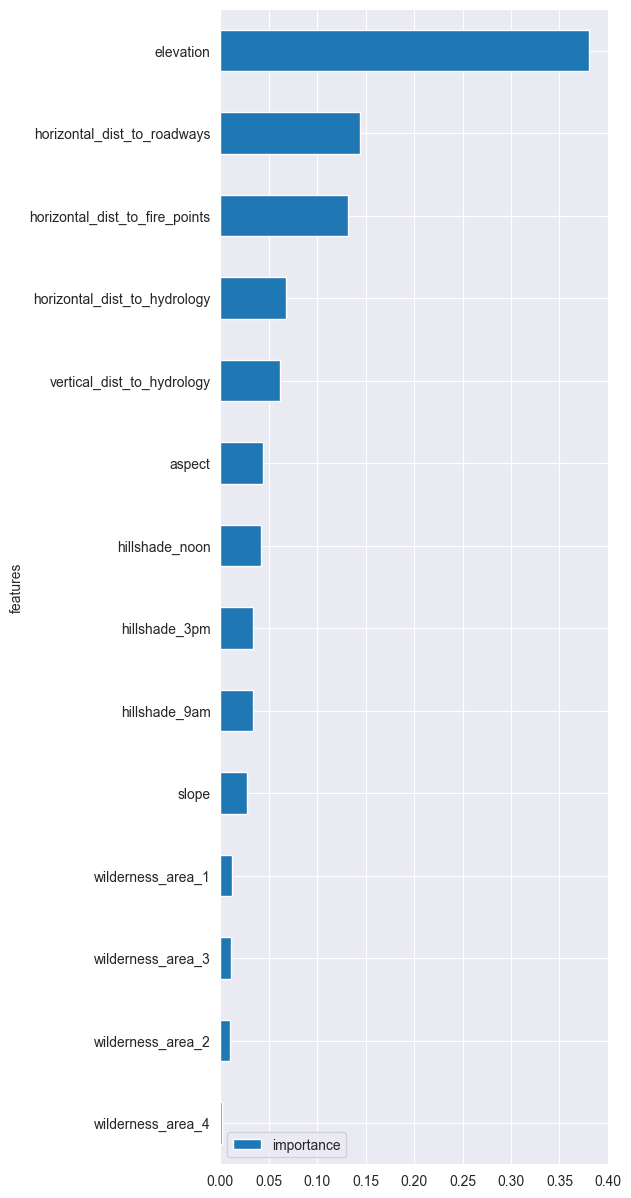

In [17]:
# plot global feature importances
importance_scores = gs.best_estimator_.named_steps["clf"].feature_importances_.tolist()
feature_names = X.columns.tolist()

pd.DataFrame(
    zip(feature_names, importance_scores), columns=["features", "importance"]
).set_index("features").sort_values("importance").plot(kind="barh", figsize=(5, 15))

In [18]:
# sort features by importance and get ranked names
ranked_features = sorted(
    zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True
)
ranked_features = [feat[0] for feat in ranked_features]

In [19]:
ranked_features

['elevation',
 'horizontal_dist_to_roadways',
 'horizontal_dist_to_fire_points',
 'horizontal_dist_to_hydrology',
 'vertical_dist_to_hydrology',
 'aspect',
 'hillshade_noon',
 'hillshade_3pm',
 'hillshade_9am',
 'slope',
 'wilderness_area_1',
 'wilderness_area_3',
 'wilderness_area_2',
 'wilderness_area_4']

In [20]:
# save out a copy of the "undrifted" full dataset
# with open("../data/covtype_nodrift_norm.pkl", "wb") as f:
#     pickle.dump(df, f)

### 3. Separate dataset by chunks + shuffle feature values

Let's induce 3 ChangePoints in the dataset, resulting in 4 different, sequential concepts.
1. Original data distribution - no induced drift
2. Rotate values for top 4 most important features
3. Rotate values for middle 6 features ranked by importance
4. Rotate values for bottom 4 least important features


In [21]:
import copy
import random

In [22]:
# chunk_to_feature_rank_strategy = {0: None, 1: (0, 4), 2: (4, 10), 3: (10, 14)} # most to least severe
chunk_to_feature_rank_strategy = {0: None, 1: (10, 14), 2: (4, 10), 3: (0, 4)} # least to most severe

def induce_drift(df, ranked_features, strategy):
    
    df = df.reset_index(drop=True)

    chunk_size = int(df.shape[0] / 4)
    change_points = list(range(0, len(df) - chunk_size, chunk_size))
    df_chunks = [df[i : i + chunk_size] for i in change_points]
    
    random.seed(42)
    shuffled_df_chunks = []

    for i, df_chunk in enumerate(df_chunks):

        # lookup feature rotation strategy
        strategy = chunk_to_feature_rank_strategy[i]

        if strategy:
            features_to_rotate = ranked_features[strategy[0] : strategy[1]]

            # get shuffled col_names to ensure all fields have actually changed index
            col_names = df_chunk[features_to_rotate].columns.tolist()
            shuffled_col_names = copy.deepcopy(col_names)

            while any(col_names[j] == shuffled_col_names[j] for j in range(len(col_names))):
                random.shuffle(shuffled_col_names)

            # rename columns with shuffled names
            shuffle_col_map = {
                col_names[k]: shuffled_col_names[k] for k in range(len(col_names))
            }
            shuffled_df_chunk = df_chunk.rename(columns=shuffle_col_map)

            shuffled_df_chunks.append(shuffled_df_chunk[df.columns.values])

        else:
            shuffled_df_chunks.append(df_chunk)

    return pd.concat(shuffled_df_chunks, axis=0), change_points


In [23]:
%%time

drift_df, change_points = induce_drift(
    df, ranked_features, chunk_to_feature_rank_strategy
)

CPU times: total: 46.9 ms
Wall time: 56.3 ms


In [24]:
# with open("../data/covtype_induced_drift.pkl", "wb") as f:
#     pickle.dump((drift_df, change_points), f)

# with open("../data/covtype_induced_drift.pkl", "rb") as f:
#     drift_df, change_points = pickle.load(f)

### Induce drift forward chain

This version corrects the previous method by ensurin that drift is induced in a forward chaining strategy so that concepts persist throughout entire dataset from a given changepoint.

In [25]:
chunk_to_feature_rank_strategy = {0: None, 1: (0, 4), 2: (4, 10), 3: (10, 14)} # most to least severe

def induce_drift_forward(df, ranked_features, rotation_strategy):
    
    df = df.reset_index(drop=True)

    chunk_size = int(df.shape[0] / 4)
    change_points = list(range(0, len(df) - chunk_size, chunk_size))
    chunk_end_idxs = [i + chunk_size for i in change_points]

    drift_df = copy.deepcopy(df)
    
    for i, change_point in enumerate(change_points):

        # lookup feature rotation strategy
        strategy = rotation_strategy[i]

        if strategy:

            # grab records that need to be rotated - chained foward
            working_df = copy.deepcopy(drift_df[change_point:])

            features_to_rotate = ranked_features[strategy[0] : strategy[1]]

            # get shuffled col_names to ensure all fields have actually changed index
            col_names = working_df[features_to_rotate].columns.tolist()
            shuffled_col_names = copy.deepcopy(col_names)

            while any(col_names[j] == shuffled_col_names[j] for j in range(len(col_names))):
                random.shuffle(shuffled_col_names)

            # rename columns with shuffled names
            shuffle_col_map = {
                col_names[k]: shuffled_col_names[k] for k in range(len(col_names))
            }
            shuffled_working_df = working_df.rename(columns=shuffle_col_map)

            # update drift_df to overwrite the new records from working df
            drift_df = drift_df.iloc[:change_point]
            drift_df = drift_df.append(shuffled_working_df)

    return drift_df, change_points
   


In [26]:
%%time

drift_df, change_points = induce_drift_forward(
    df, ranked_features, chunk_to_feature_rank_strategy
)

CPU times: total: 172 ms
Wall time: 167 ms


C:\Users\MarcellNemeth\AppData\Local\Temp\ipykernel_3840\1378920098.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  drift_df = drift_df.append(shuffled_working_df)
C:\Users\MarcellNemeth\AppData\Local\Temp\ipykernel_3840\1378920098.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  drift_df = drift_df.append(shuffled_working_df)
C:\Users\MarcellNemeth\AppData\Local\Temp\ipykernel_3840\1378920098.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  drift_df = drift_df.append(shuffled_working_df)


In [27]:
# with open("../data/covtype_induced_drift_forward_norm.pkl", "wb") as f:
#     pickle.dump((drift_df, change_points), f)

# with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
#     drift_df, change_points = pickle.load(f)

### Are targets distributed evenly among concepts?

In [28]:
drift_df.iloc[: change_points[1]].cover_type.value_counts()

1.0    70845
0.0    52940
Name: cover_type, dtype: int64

In [29]:
drift_df.iloc[change_points[1] : change_points[2]].cover_type.value_counts()

1.0    70842
0.0    52943
Name: cover_type, dtype: int64

In [30]:
drift_df.iloc[change_points[2] : change_points[3]].cover_type.value_counts()

1.0    70635
0.0    53150
Name: cover_type, dtype: int64

In [31]:
drift_df.iloc[change_points[3] :].cover_type.value_counts()

1.0    70979
0.0    52807
Name: cover_type, dtype: int64